In [ ]:
from google.colab import files
uploaded = files.upload();



Saving 319080_643971_bundle_archive.zip to 319080_643971_bundle_archive.zip


In [ ]:
import sys
import os
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as k
import cv2
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split

DESCRIPCION DE DATASET

In [ ]:
##DESCRIPCION DEL DATASET
##Este  data set contiene imagenes de los tipos de cancer los cuales estan clasificadas
#deacuerdo a diferentes etiquetas. 
#Datos divididos en conjuntos de tren, prueba y validación en formato ImageFolder.
#Las etiquetas son:
#0 - queratosis actínica
#1 - carcinoma de células basales
#2 - dermatofibroma
#3 - melanoma
#4 - nevo
#5 - queratosis benigna pigmentada
#6 - queratosis seborreica
#7 - carcinoma de células escamosas
#8 - lesión vascular.
import zipfile
import io
data= zipfile.ZipFile(io.BytesIO(uploaded['319080_643971_bundle_archive.zip']),'r')
data.extractall()

In [ ]:
k.clear_session()
##FUNCION QUE PERMITE OBTENER LA DESCRIPCION DE UNA IMAGEN PARTICULAR
def display_stats(numero,nombre):
    num=str(numero)
    nombre=str(nombre)
    img="/content/data/train/"+num+"/"+nombre+".png"
    img=cv2.imread(img)
    print(img.shape)
    img_cvt=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



In [ ]:
#SEPARACION DE TRAIN Y TEST 
data_entrenamiento="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
data_validacion="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

In [ ]:
#PARAMETROS PARA LA NORMALIZACION DE LAS IMAGENES Y LA FASE DE ENTRENAMIENTO 
#Altura y longitud hacen referencia al tamano de la imagen altura=100 y longitud=100
#clases=7 ya que existen 7 clases disponibles para la clasificacion del dataset

altura, longitud=100,100
batch_size=32
filtrosConv1=32
filtrosConv2=64
tamano_filtro1=(3,3)
tamano_filtro2=(2,2)
tamano_pool=(2,2)
clases=9

In [ ]:
#PREPROCESAMIENTO DE IMAGENES
entrenamiento_datagen= ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

In [ ]:
#VALIDACION
validacion_datagen=ImageDataGenerator(
    rescale=1./255
)

In [ ]:
imagen_entrenamiento= entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura,longitud),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
imagen_validacion=validacion_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura,longitud),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)



Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [ ]:
import seaborn as sns
#para ver los path
#print (imagen_validacion.filepaths)
#pra ver los nombres
#print (imagen_validacion.filenames)
#print (imagen_validacion.labels)
#ver altura,longitud , canal
#print (imagen_validacion.image_shape)
nombres=[imagen_validacion]
img_list=[imagen_validacion.filenames,imagen_validacion.filepaths,imagen_validacion.labels]
df = pd.DataFrame(img_list )

print(df.head)

#df = df.T
#df.columns = ["img_name", "path","label"]
#print(df)









<bound method NDFrame.head of                                                    0  ...                                                117
0                 actinic keratosis/ISIC_0010512.jpg  ...                   vascular lesion/ISIC_0024402.jpg
1  /content/Skin cancer ISIC The International Sk...  ...  /content/Skin cancer ISIC The International Sk...
2                                                  0  ...                                                  8

[3 rows x 118 columns]>


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df[["img_name","path","label"]], df["label"], test_size=0.2, stratify = df["label"], random_state = 754142)




In [ ]:
#INICIAMOS EL MODELO RED REURONAL CNN
cnn = Sequential()
#Añadimos una capa convolucional con 32 filtros de 3píxeles de ancho x 3píxeles de altura. Vamos a aplicarlo a cada imagen. 
#Cada filtro sería de: 3x3.
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape=(longitud, altura, 3), activation='relu'))
#añadimos una capa de pooling de 2x2
cnn.add(MaxPooling2D(pool_size=tamano_pool))
#Añadimos una capa convolucional con 64 filtros de 3píxeles de ancho x 3píxeles de altura. Vamos a aplicarlo a cada imagen. 
#Cada filtro sería de: 2x2.
cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding ="same"))
#añadimos una capa de pooling de 2x2
cnn.add(MaxPooling2D(pool_size=tamano_pool))
#añadimos una capa para aplanar la estructura y convertir en una matriz
cnn.add(Flatten())


In [ ]:
#añadimos una capa con 64 neuronas
cnn.add(Dense(64,activation='relu'))
#añadimos una capa con 32 neuronas
cnn.add(Dense(128,activation='sigmoid'))
#este dropout desactiva el 50% de las conexiones entre las neuronas, lo cual mejora los resultados
cnn.add(Dropout(0.5))
#en la última capa tiene que hacer tantas neuronas como clases haya, en este caso clases=7 
cnn.add(Dense(clases,activation='softmax'))
#compilamos el modelo
cnn.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
print(imagen_validacion)


In [ ]:
#Fase de training
#hacemos que la red recorra la fase de entrenamiento (epochs) 100 veces.
history=cnn.fit(imagen_entrenamiento,steps_per_epoch=50,epochs=100, validation_data=imagen_validacion,validation_steps=0.2)
#en 50 epochs aproximadamente: loss: 0.4032 - accuracy: 0.8588

Epoch 1/100
50/50 [==============================] - 50s 992ms/step - loss: 2.1993 - accuracy: 0.1964 - val_loss: 2.3044 - val_accuracy: 0.1562
Epoch 2/100
50/50 [==============================] - 49s 983ms/step - loss: 1.9206 - accuracy: 0.2958 - val_loss: 2.2973 - val_accuracy: 0.1875
Epoch 3/100
50/50 [==============================] - 51s 1s/step - loss: 1.7493 - accuracy: 0.3812 - val_loss: 2.4620 - val_accuracy: 0.1875
Epoch 4/100
50/50 [==============================] - 48s 967ms/step - loss: 1.6691 - accuracy: 0.4128 - val_loss: 2.3955 - val_accuracy: 0.1875
Epoch 5/100
50/50 [==============================] - 50s 998ms/step - loss: 1.6360 - accuracy: 0.4178 - val_loss: 1.9371 - val_accuracy: 0.3438
Epoch 6/100
50/50 [==============================] - 46s 917ms/step - loss: 1.5874 - accuracy: 0.4469 - val_loss: 1.9882 - val_accuracy: 0.3125
Epoch 7/100
50/50 [==============================] - 51s 1s/step - loss: 1.5331 - accuracy: 0.4581 - val_loss: 2.0870 - val_accuracy: 0.343

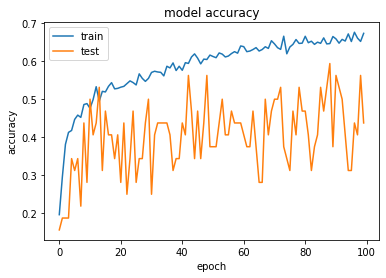

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

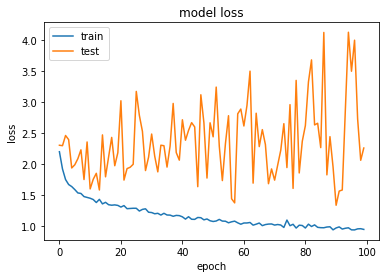

In [ ]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import tensorflow as tf
import numpy
import os
# serialize model to JSON
model_json = cnn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Saved model to disk
Loaded model from disk


In [ ]:
#RESUMEN DE LA RED NEURONAL
cnn.summary()
#GUARDAR LOS PESOS Y EL MODELO DE LA RED NEURONAL
#cnn.save('/content/modelo/modelo.h5')
#cnn.save_weights('/content/modelo/pesos.h5')


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 64)        8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2560064   
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

In [ ]:
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 64)        8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2560064   
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
longitud,altura=100,100



In [ ]:
#FUNCION PARA RECIBIR UNA IMAGEN Y PREDECIR LA CLASE DE LA IMAGEN JUNTO CON LA PROBABILIDAD 
def predict(file):
  x=load_img(file,target_size=(100,100))
  x=img_to_array(x)
  x=np.expand_dims(x, axis=0)
  arreglo= loaded_model.predict(x)
  resultado= arreglo[0]
  maxElement = np.amax(resultado)
  MaxElement='%.2f'%(maxElement*100)
  respuesta=np.argmax(resultado)
  print("Con una probabilidad de "+MaxElement+"% esta: ")
  if respuesta==0:
    print('ACTINITIC KERATOSIS')
  elif respuesta==1:
    print('BASAL CELL CARCINOMA')
  elif respuesta==2:
    print('DERMATOFIBRONA')
  elif respuesta==3:
    print('MELANOMA')
  elif respuesta==4:
    print('NEVUS')
  elif respuesta==5:
    print('PIGMENTED BENIGN KERATOSIS')
  elif respuesta==6:
    print('SEBORRHEIC KERATOSIS')
  elif respuesta==7:
    print('SQUAMUS CELL CARCINOMA')
  elif respuesta==8:
    print('VASCULAR LESION')
  return respuesta


In [ ]:
from google.colab import files
uploaded = files.upload();

Saving vascularlesion.jpg to vascularlesion.jpg


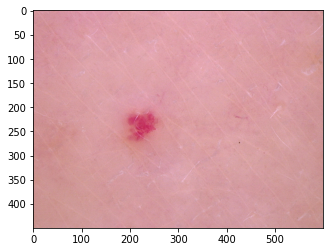

Con una probabilidad de 85.94% esta: 
MELANOMA


3

In [ ]:
img=cv2.imread("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024375.jpg")
img_cvt=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
predict('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024375.jpg')

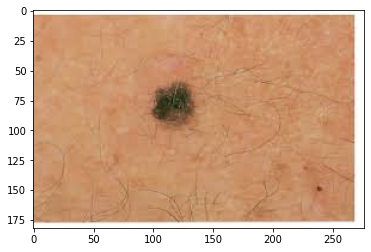

Con una probabilidad de 75.49% esta: 
MELANOMA


3

In [ ]:
img=cv2.imread("/content/MELANOMA.jpeg")
img_cvt=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
predict('/content/MELANOMA.jpeg')